In [1]:
!nvidia-smi

Fri Dec 11 09:29:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
 
import torch.nn as nn
import torch.nn.functional as F

import time

# 0-2. Set Hyper Parameters (Model2)

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trial = 27
# Hyper parameters
batch_size = 256
num_epochs = 9

num_classes = 47
out1 = 64
kernel = 5
padding = 2
out2 = 128
out3 = 512
out4 = 128
drop1 = 0
drop2 = 0
out5 = 256
drop3 = 0

# 1-2. Load Data (Model2)

In [89]:
dataset2 = torchvision.datasets.EMNIST(root='./',
                                        split='bymerge',
                                        train=True,
                                        transform=transforms.Compose([transforms.ToTensor()]),
                                        download=True)
train_data2, val_data2 = torch.utils.data.random_split(dataset2, [int(len(dataset2)*0.9)+1, int(len(dataset2)*0.1)])
test_data2 = torchvision.datasets.EMNIST(root='./',
                                        split='bymerge',
                                        train=True,
                                        transform=transforms.Compose([transforms.ToTensor()]),
                                        download=True)

# 2-2. Define DataLoader

In [92]:
train_loader2 = torch.utils.data.DataLoader(dataset=train_data2,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader2 = torch.utils.data.DataLoader(dataset=val_data2,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader2 = torch.utils.data.DataLoader(dataset=test_data2,
                                          batch_size=batch_size,
                                          shuffle=False)

# 3-2. Define Model2

In [93]:
class Model2(nn.Module):
  def __init__(self, num_classes, out1, kernel, padding, out2, out3, out4, drop1, drop2, out5, drop3):
    super(Model2, self).__init__()
    self.num_classes = num_classes
    self.out1 = out1
    self.kernel = kernel
    self.padding = padding
    self.out2 = out2
    self.out3 = out3
    self.out4 = out4
    self.drop1 = drop1
    self.drop2 = drop2
    self.out5 = out5
    self.drop3 = drop3

    self.cnn1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=out1, kernel_size=kernel+4, stride=1, padding=padding+2),
        nn.Dropout(drop1),
        nn.BatchNorm2d(out1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.cnn2 = nn.Sequential(
        nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=kernel, stride=1, padding=padding),
        nn.Dropout(drop2),
        nn.BatchNorm2d(out2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.cnn3 = nn.Sequential(
        nn.Conv2d(in_channels=out2, out_channels=out5, kernel_size=kernel-2, stride=1, padding=padding-1),
        nn.Dropout(drop3),
        nn.BatchNorm2d(out5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    def downsize(input_size, padding, kernel):
      return (input_size+(padding*2)-kernel+1)//2
    s = downsize(28, padding+2, kernel+4)
    s = downsize(s, padding, kernel)
    s = downsize(s, padding-1, kernel-2)
    self.fc1 = nn.Sequential(
        nn.Linear(s*s*out5, out3),
        nn.BatchNorm1d(out3)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(out3, out4),
        nn.BatchNorm1d(out4)
    )
    self.fc3 = nn.Linear(out4, num_classes)

  def forward(self, x):
    # comment: tensor size after passed trough each layer
    x = self.cnn1(x) # 256x64x14x14(batch size x num output x wide x height)
    x = self.cnn2(x) # 256x128x7x7 (batch size x num output x wide x height)
    x = self.cnn3(x) # 256x256x3x3 (batch size x num output x wide x height)
    x = x.reshape(x.size(0), -1) # 256x(256x3x3) (batch size x (num output x wide x height))
    x = F.relu(self.fc1(x)) # 256x512 (batch size x num output)
    x = F.relu(self.fc2(x)) # 256x128 (batch size x num output)
    x = F.softmax(self.fc3(x), dim=1) # 256x47 (batch size x num output)
    return x

In [94]:
model2 = Model2(num_classes, out1, kernel, padding, out2, out3, out4, drop1, drop2, out5, drop3).to(device)

In [95]:
print(model2)

Model2(
  (cnn1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1)

# 4-2. Define Loss / Optimizer (Model2)

In [96]:
learning_rate = 0.0007

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

# 5-2. Train (Model2)

In [97]:
print(f'시행 {trial} train')
t1 = time.time()

train_loss_list = []
train_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

for epoch in range(num_epochs):
  running_loss = 0
  right = 0 # the number of right prediction
  for i, (img, lbl) in enumerate(train_loader2):
    img = img.to(device)
    lbl = lbl.to(device)

    # Forward
    out = model2(img).to(device)

    # Get Loss / Compute Gradient / Update Parameters
    loss = criterion(out, lbl)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # sum training loss and right prediction
    running_loss += loss.item()
    _, pred = torch.max(out, 1)
    right += (pred==lbl).sum().item()
      
    # validation checking for end of each epoch
    if (i+1)==len(train_loader2):

      # Compute Train Accuracy and Loss
      train_acc = right/len(train_data2) # mean of right prediction
      train_loss = running_loss/len(train_loader2) # mean of running loss

      # Compute Validation Loss & Accuracy
      with torch.no_grad():
        val_right = 0
        val_loss = 0
        for v, (val_img, val_lbl) in enumerate(val_loader2):
          val_img = val_img.to(device)
          val_lbl = val_lbl.to(device)

          val_out = model2(val_img)
          val_loss += criterion(val_out, val_lbl).item()

          _, val_pred = torch.max(val_out, 1)
          val_right += (val_pred==val_lbl).sum().item()
        val_loss = val_loss / len(val_loader2)
        val_acc = val_right / len(val_data2)
      
      # Check Loss & Accuracy
      print(f'Epoch: [{epoch+1}/{num_epochs}] Step: [{i+1}/{len(train_loader2)}], ', end='')
      print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.4f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc*100:.4f}%', end=' ')
      print(f'걸린 시간: {time.time()-t1:.4f}초')
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_acc)
  validation_loss_list.append(val_loss)
  validation_accuracy_list.append(val_acc)

t2 = time.time()
print(f'걸린 시간: {t2-t1:.4f}초')

시행 27 train
Epoch: [1/9] Step: [2454/2454], Train Loss: 3.0640, Train Accuracy: 83.1833%, Validation Loss: 3.0029, Validation Accuracy: 88.6034% 걸린 시간: 78.1104초
Epoch: [2/9] Step: [2454/2454], Train Loss: 2.9954, Train Accuracy: 89.2947%, Validation Loss: 2.9922, Validation Accuracy: 89.5634% 걸린 시간: 156.5390초
Epoch: [3/9] Step: [2454/2454], Train Loss: 2.9892, Train Accuracy: 89.8312%, Validation Loss: 2.9904, Validation Accuracy: 89.7382% 걸린 시간: 234.2128초
Epoch: [4/9] Step: [2454/2454], Train Loss: 2.9855, Train Accuracy: 90.1638%, Validation Loss: 2.9871, Validation Accuracy: 90.0105% 걸린 시간: 311.1079초
Epoch: [5/9] Step: [2454/2454], Train Loss: 2.9816, Train Accuracy: 90.5384%, Validation Loss: 2.9871, Validation Accuracy: 90.0133% 걸린 시간: 388.2401초
Epoch: [6/9] Step: [2454/2454], Train Loss: 2.9799, Train Accuracy: 90.6896%, Validation Loss: 2.9850, Validation Accuracy: 90.1709% 걸린 시간: 464.7859초
Epoch: [7/9] Step: [2454/2454], Train Loss: 2.9780, Train Accuracy: 90.8753%, Validation 

## 5-2-2. Plot Accuracy & Loss

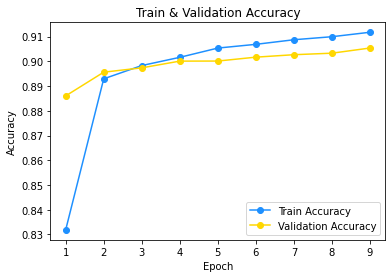

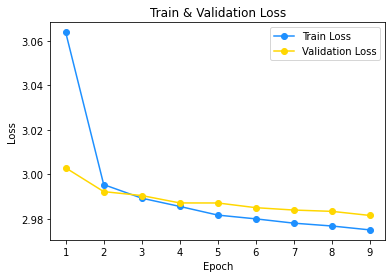

In [98]:
plt.plot(np.arange(1, num_epochs+1), train_accuracy_list, 
         label='Train Accuracy', marker='o', color='dodgerblue')
plt.plot(np.arange(1, num_epochs+1), validation_accuracy_list, 
         label='Validation Accuracy', marker='o', color='gold')
plt.legend()
plt.title('Train & Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(ticks=np.arange(1,num_epochs+1), label=np.arange(1,num_epochs+1))
plt.ylabel('Accuracy')
# plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/모델2/accuracy_{trial}_3.png')
plt.show()

plt.plot(np.arange(1, num_epochs+1), train_loss_list, 
         label='Train Loss', marker='o', color='dodgerblue')
plt.plot(np.arange(1, num_epochs+1), validation_loss_list, 
         label='Validation Loss', marker='o', color='gold')
plt.legend()
plt.title('Train & Validation Loss')
plt.xlabel('Epoch')
plt.xticks(ticks=np.arange(1,num_epochs+1), label=np.arange(1,num_epochs+1))
plt.ylabel('Loss')
plt.title('Train & Validation Loss')
# plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/모델2/loss_{trial}_3.png')
plt.show()

# 6-2. Test (Model2)

In [99]:
test_acc = 0
with torch.no_grad():
  for i, (img, lbl) in enumerate(test_loader2):
    img = img.to(device)
    lbl = lbl.to(device)

    pred = model2(img)
    _, pred = torch.max(pred, 1)

    test_acc += (pred==lbl).sum().item() / len(lbl)
  test_acc /= len(test_loader2)
  print(f'Test Accuracy of Model2 on the {len(test_data2)} images: {test_acc*100:.2f}%')

Test Accuracy of Model2 on the 697932 images: 91.31%


# 7-2. Save Model2

In [100]:
torch.save(model2.state_dict(), 'model2.pth')

# 8-2. Load Model2

In [103]:
# 시행27 최종 선정 model hyper parameters
batch_size = 256
num_classes = 47
out1 = 64
kernel = 5
padding = 2
out2 = 128
out3 = 512
out4 = 128
drop1 = 0
drop2 = 0
out5 = 256
drop3 = 0

loaded_model2 = Model2(num_classes, out1, kernel, padding, out2, out3, out4, drop1, drop2, out5, drop3).to(device)
loaded_model2.load_state_dict(torch.load('model2.pth'))

<All keys matched successfully>

# 9-2. Test with Loaded Model2


In [110]:
test_acc = 0
with torch.no_grad():
  for i, (img, lbl) in enumerate(test_loader2):
    img = img.to(device)
    lbl = lbl.to(device)

    pred = loaded_model2(img)
    _, pred = torch.max(pred, 1)

    test_acc += (pred==lbl).sum().item() / len(lbl)
  test_acc /= len(test_loader2)
  print(f'Test Accuracy of Model2 on the {len(test_data2)} images: {test_acc*100:.2f}%')

Test Accuracy of Model2 on the 697932 images: 91.31%


# 10-2. Wrong Images Check

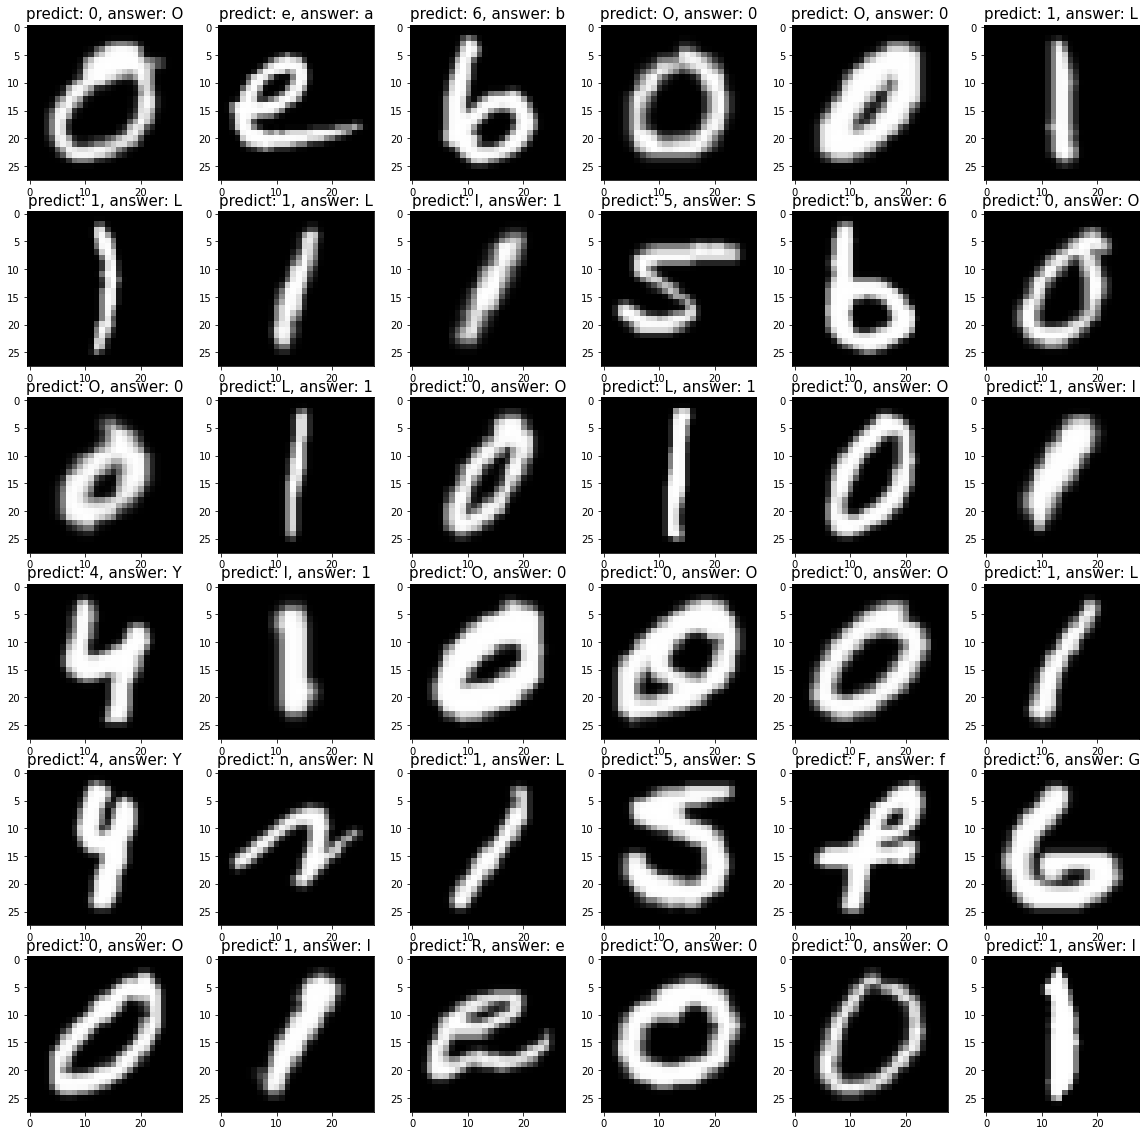

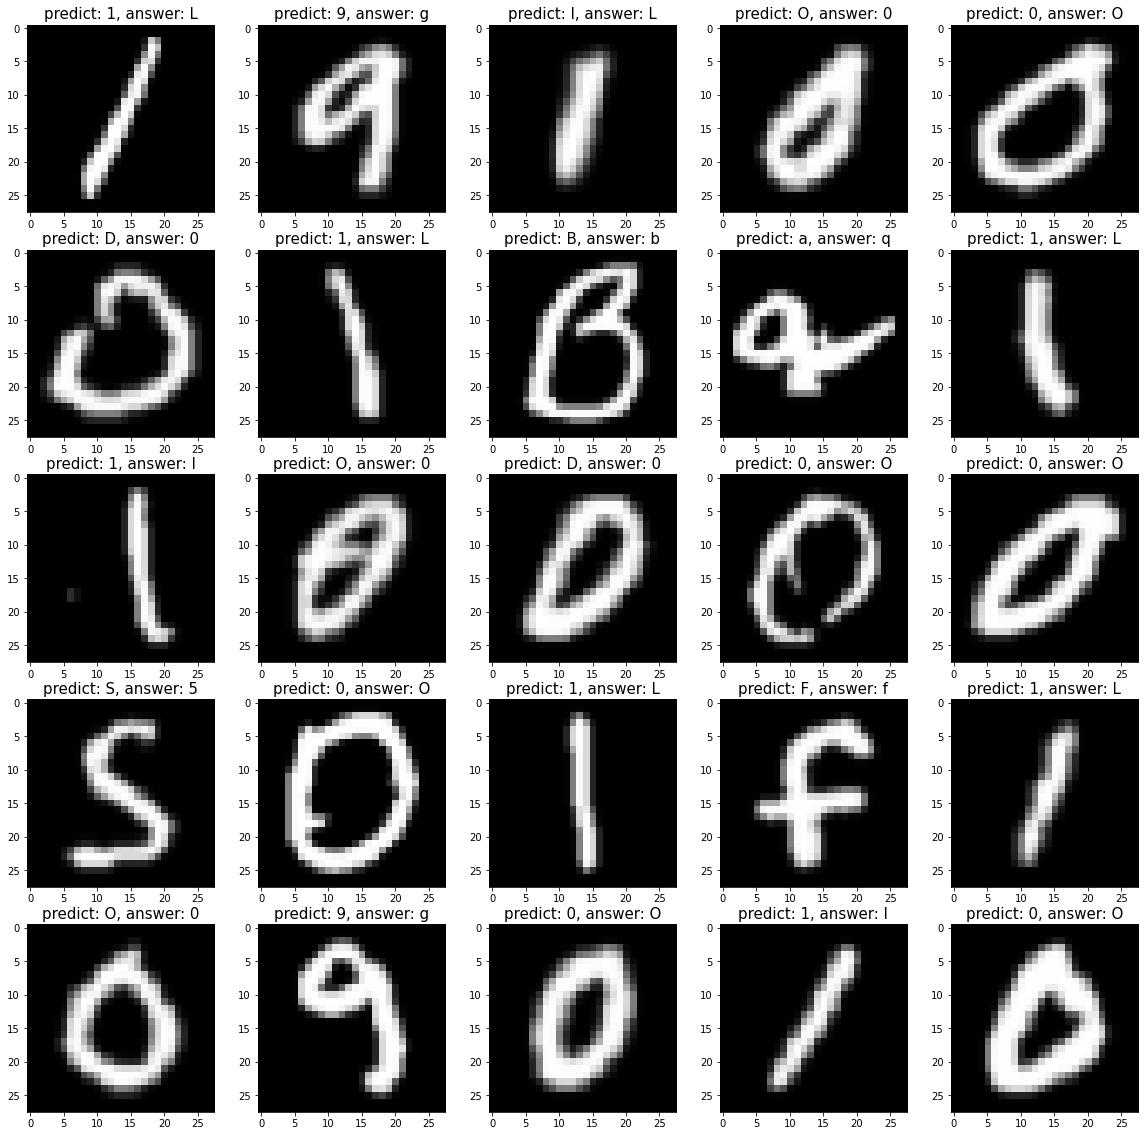

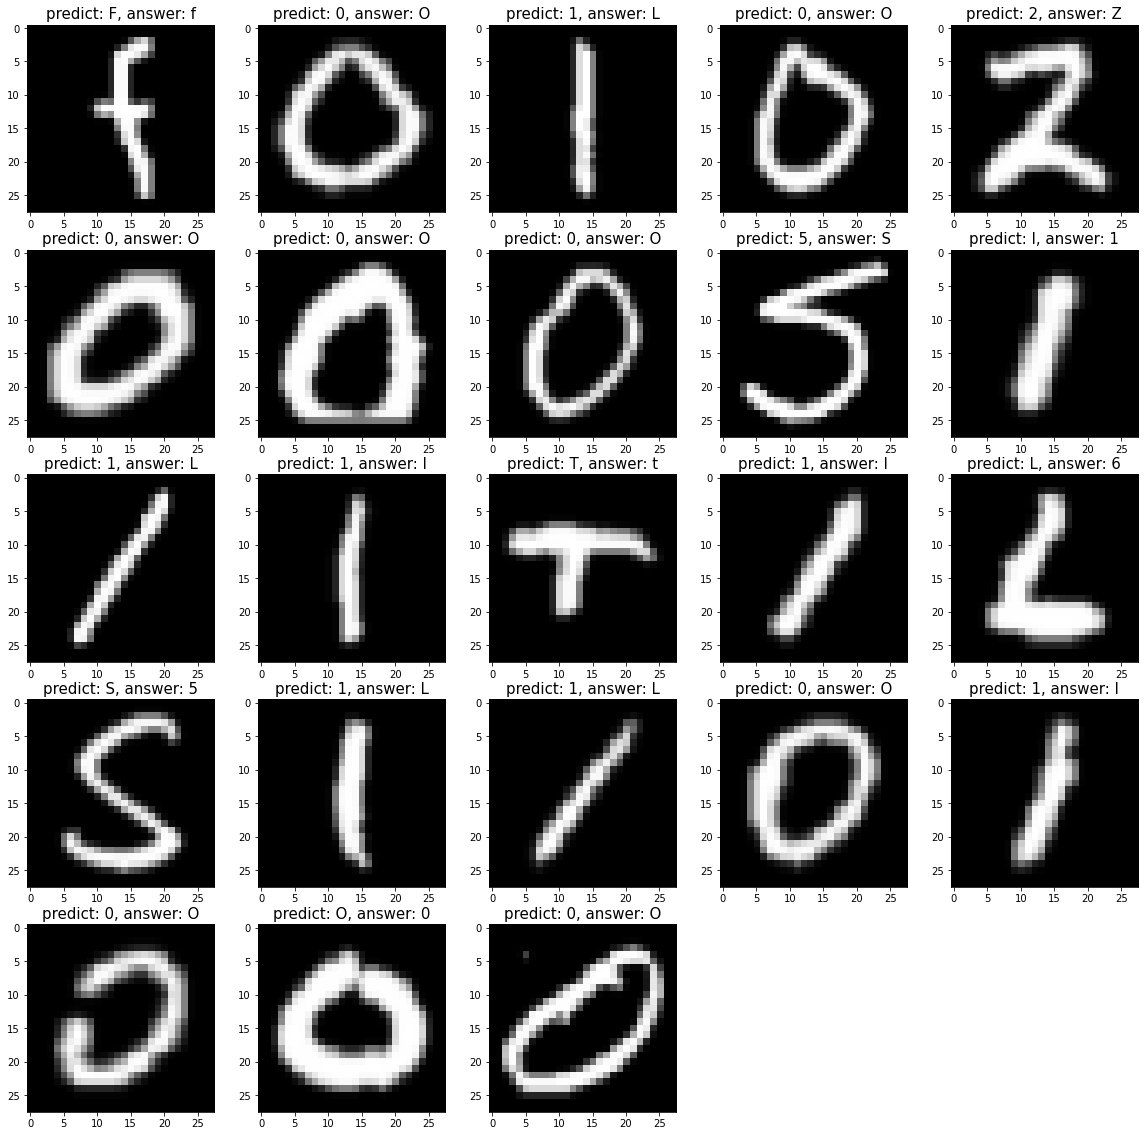

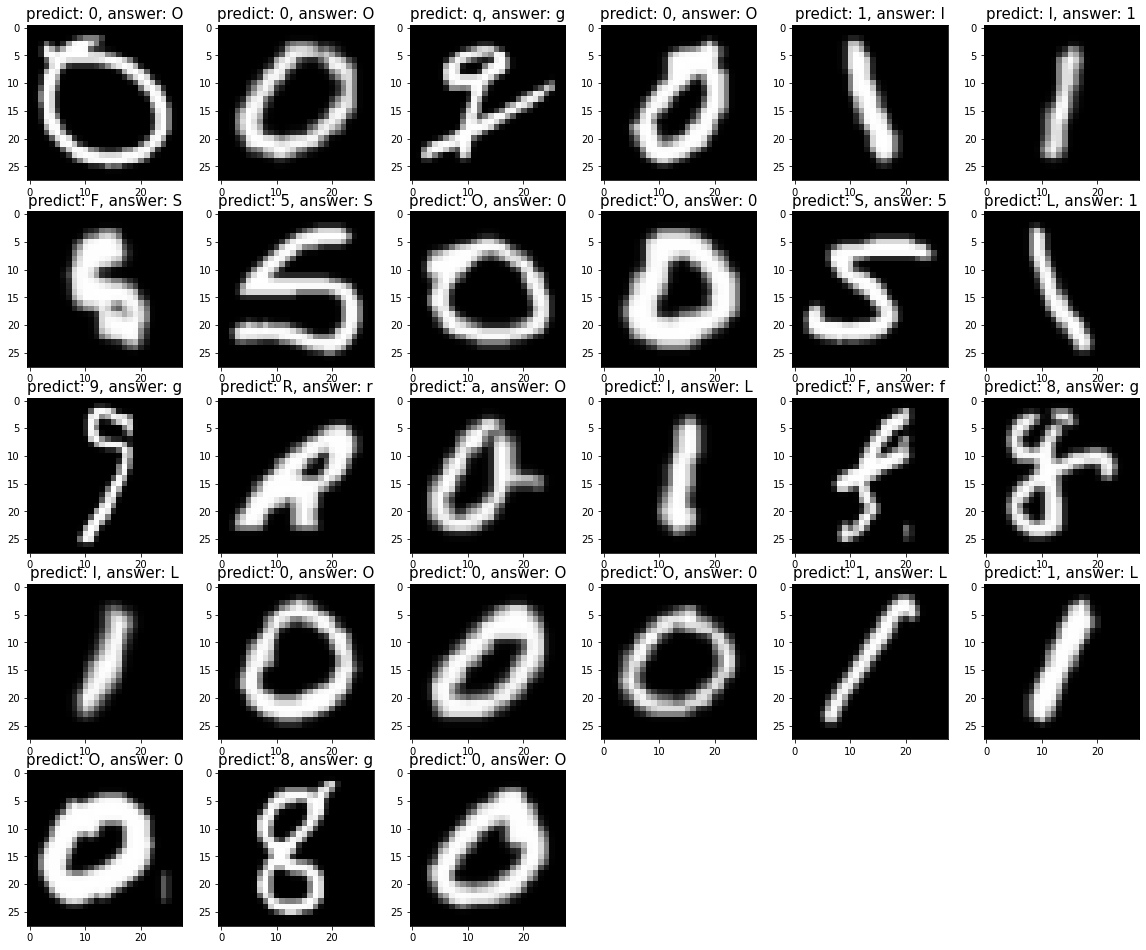

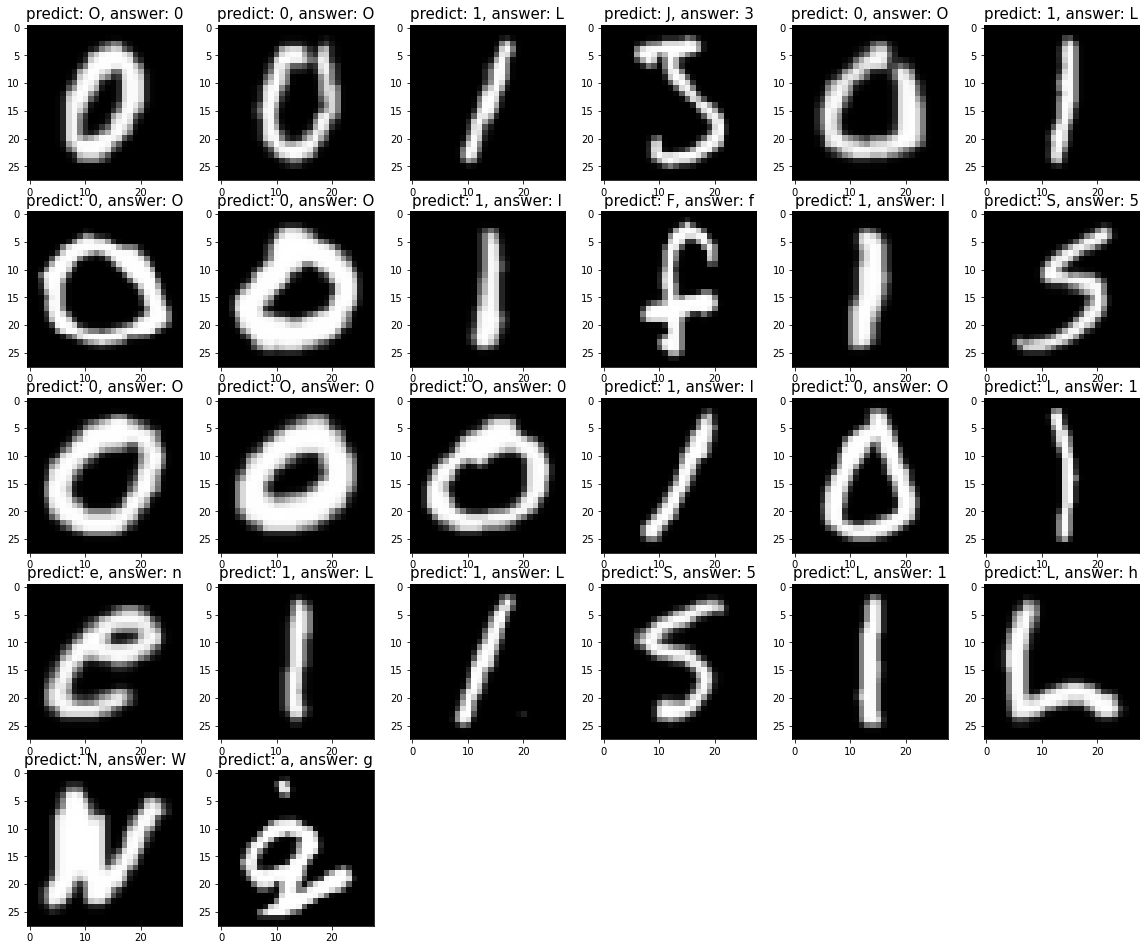

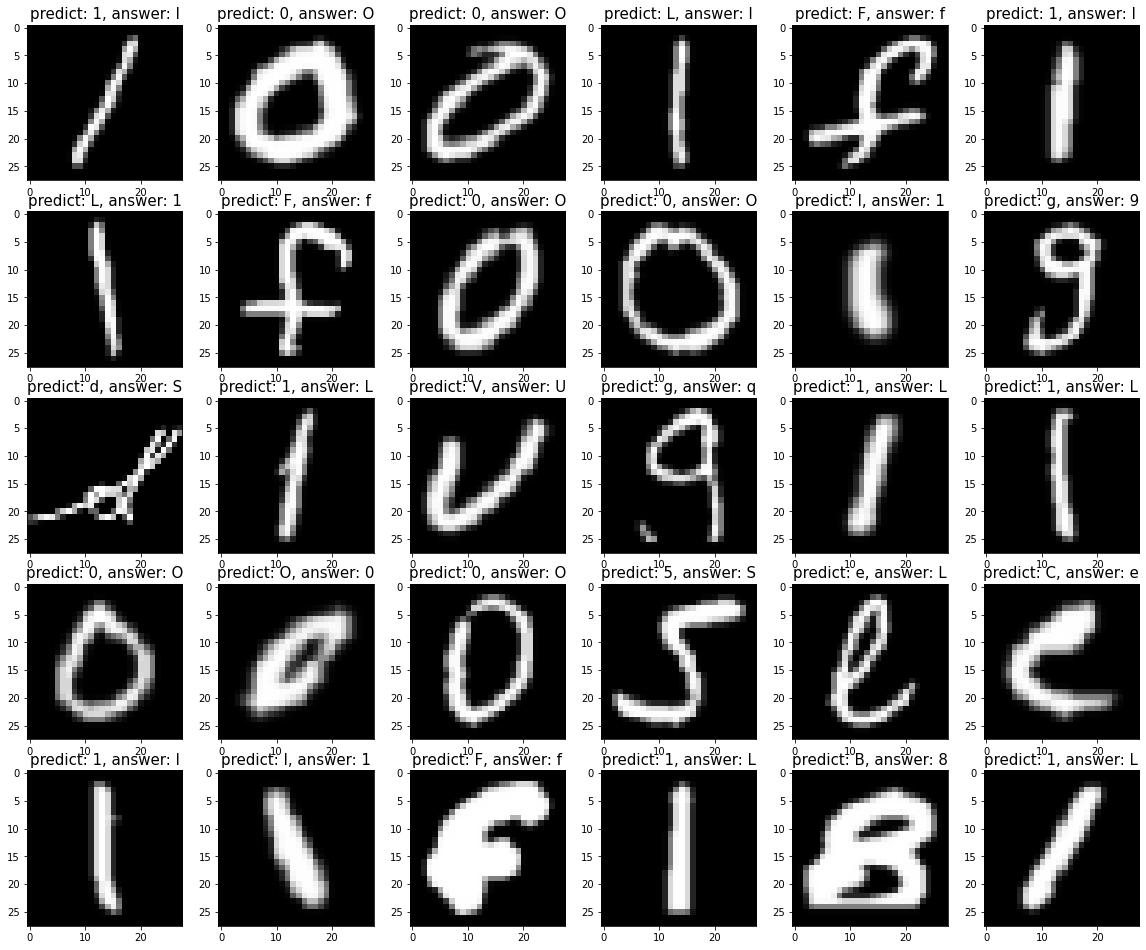

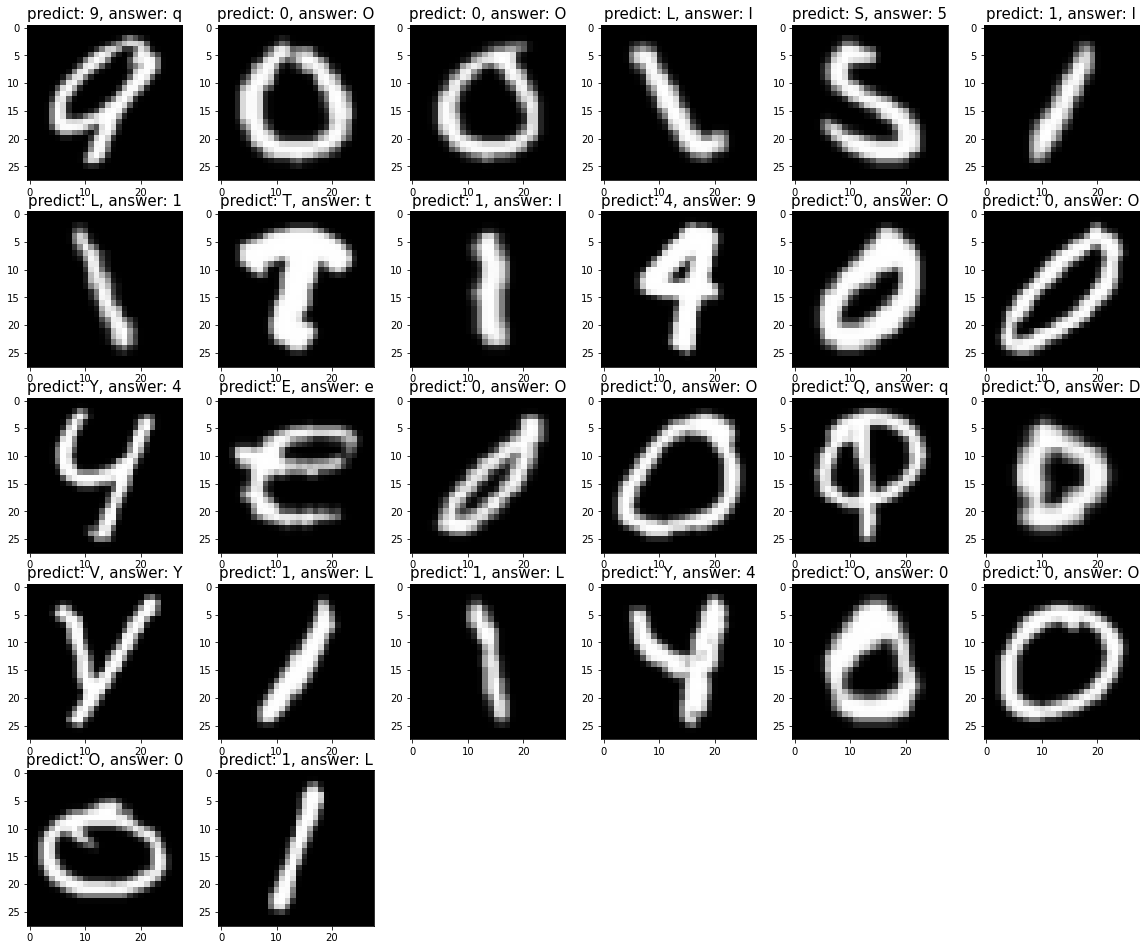

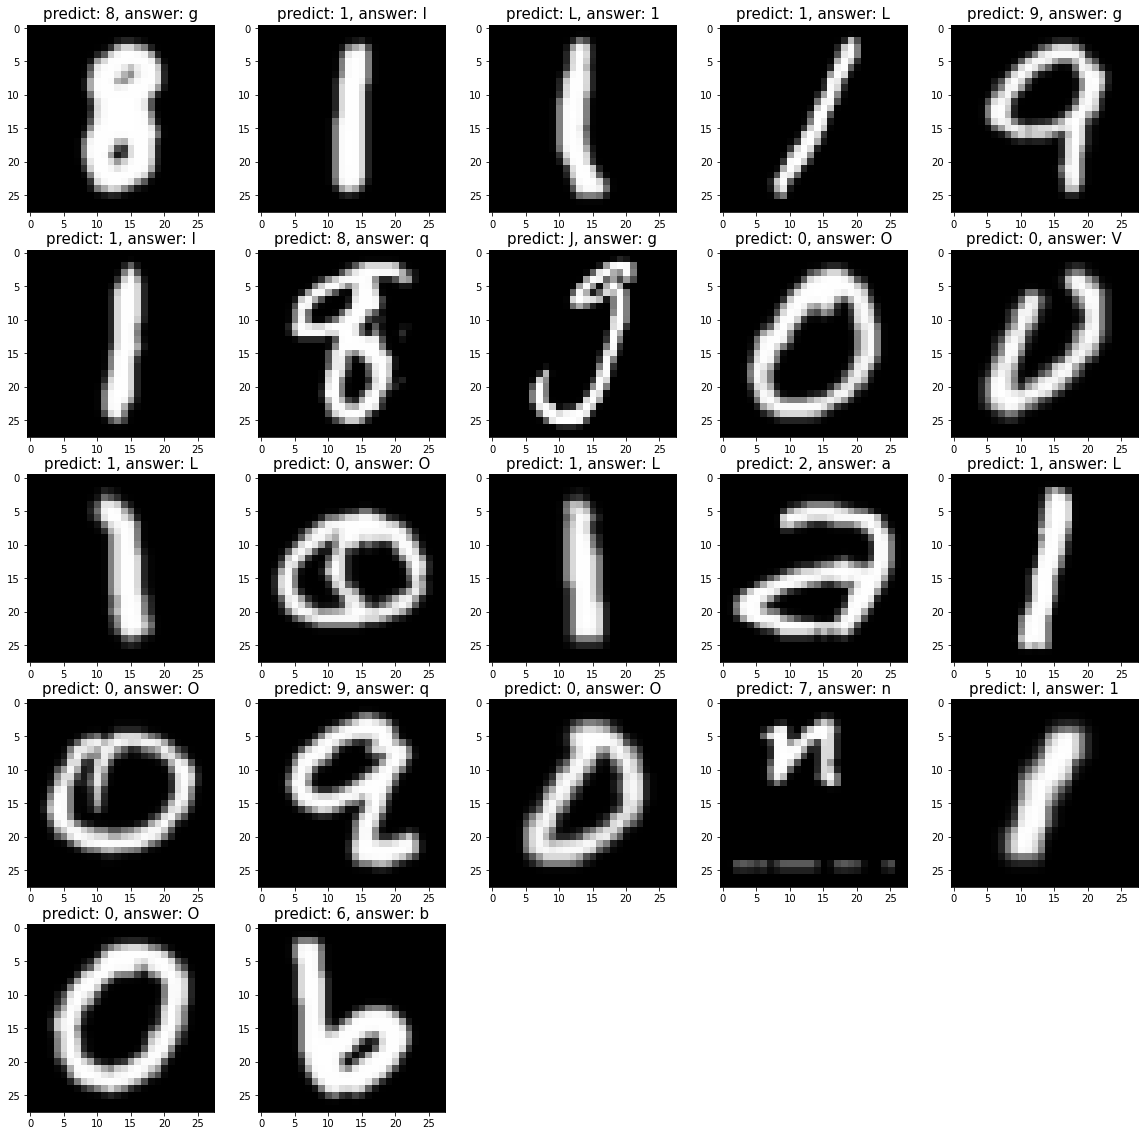

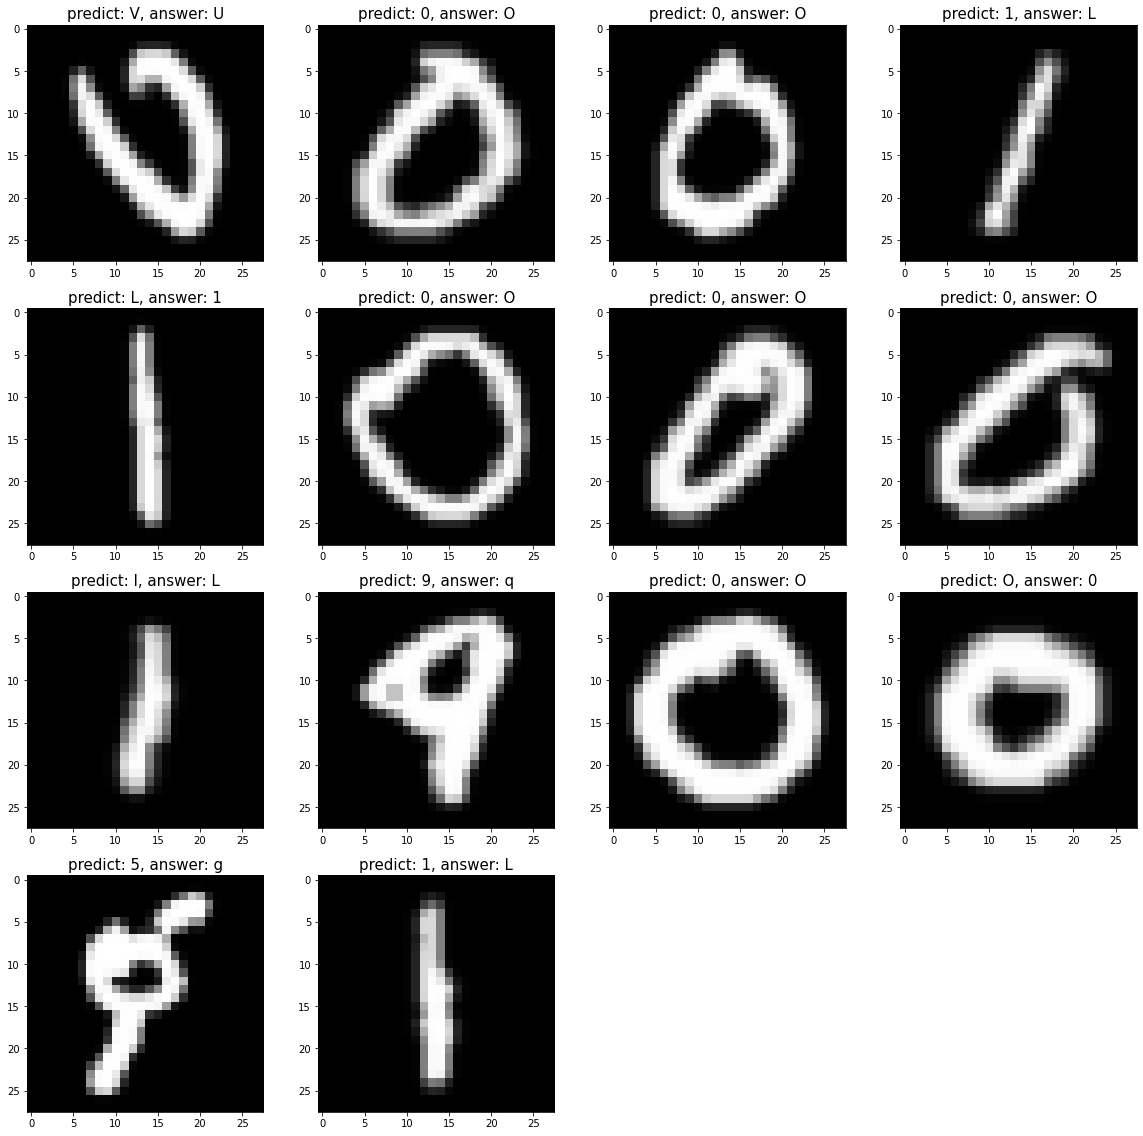

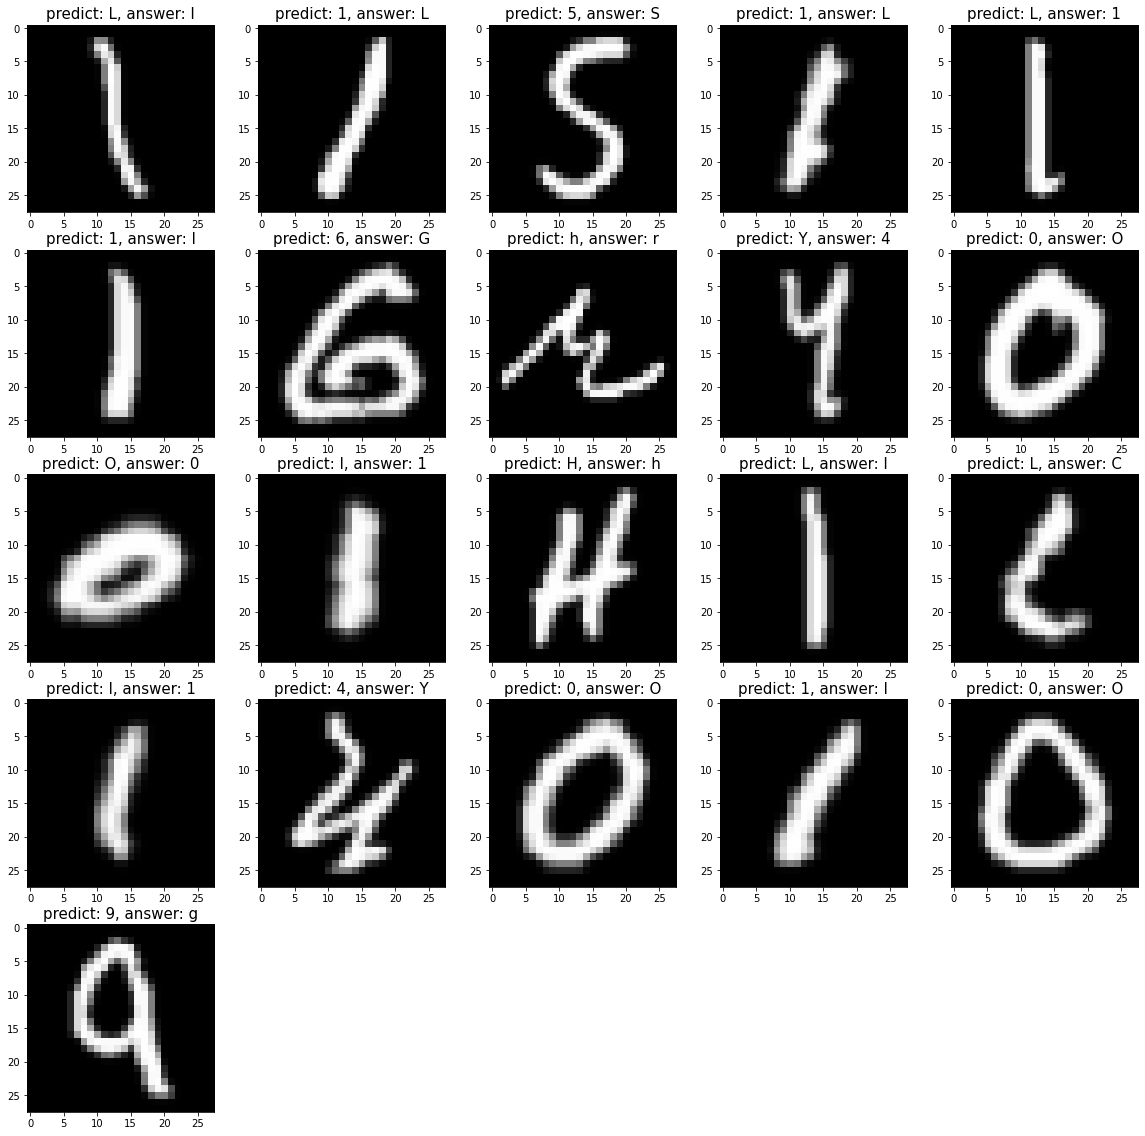

In [121]:
answer = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
for k, (img, lbl) in enumerate(test_loader2):
  if k == 10: break
  k = '0'*(2-int(np.log10(k+1)))+str(k+1)
  img = img.to(device)
  lbl = lbl.to(device) 

  fig = plt.figure(figsize=(20, 20), frameon=False)

  _, pred = torch.max(loaded_model2(img), 1)
  wrong = img[(pred!=lbl)] # wrong image
  wrong_pred = pred[(pred!=lbl)] # wrong predict
  wrong_answer = lbl[(pred!=lbl)] # real answer
  wrong = wrong.to('cpu')
  wrong_pred = wrong_pred.to('cpu')
  wrong_answer = wrong_answer.to('cpu')

  for i in range(len(wrong_pred)):
    w = wrong[i]
    wp = wrong_pred[i] # wrong predict
    wa = wrong_answer[i] # real answer

    w = w.reshape(w.size(1), w.size(2))
    w = np.fliplr(w)
    w = np.rot90(w)

    if len(wrong_pred) <= 16: fig.add_subplot(4, 4, i+1)
    elif len(wrong_pred) <= 25: fig.add_subplot(5, 5, i+1)
    elif len(wrong_pred) <= 36: fig.add_subplot(6, 6, i+1)
    elif len(wrong_pred) <= 49: fig.add_subplot(7, 7, i+1)
    elif len(wrong_pred) <= 64: fig.add_subplot(8, 8, i+1)
    plt.imshow(w, cmap=plt.cm.gray)
    plt.title(f'predict: {answer[wp]}, answer: {answer[wa]}', fontsize=15)
  # plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/wrong_image/{k}_Misclassification.png', bbox_inches='tight')
  plt.show()